In [1]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

#Bringing in all of the libraries and searching for GPU if available which will make everything faster

TF Version:  2.9.1
TF-Hub version:  0.12.0
Eager mode enabled:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available:  False


In [57]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image
#model only accepts squares, so this function centers the image and pulls a square)

def resize_image_to_square(image_np_extra, image_size=(256,256), preserve_aspect_ratio=True):
    image_np_extra = image_np_extra.astype(np.float32)[np.newaxis, ...]
    if image_np_extra.max() > 1.0:
        image_np_extra = image_np_extra / 255.
    if len(image_np_extra.shape) == 3:
     img = tf.stack([image_np_extra, image_np_extra, image_np_extra], axis=-1)
    img = crop_center(image_np_extra)
    img = tf.image.resize(image_np_extra, image_size, preserve_aspect_ratio=True)
    return image_np_extra
    
@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img
#Perserving aspect ratio and setting sizing

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()
#shows the images and shows the differences, like the original, the style image and the resulting one

In [20]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://imgur.com/kHZSqFd.jpeg'  # @param {type:"string"}
style_image_url = 'https://imgur.com/dPr5sKZ.jpeg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}
#you can change the output image size to anything you want, but the style image must be 256x256

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')   #this takes pixels from the style image and smooths them out
show_n([content_image, style_image], ['Content image', 'Style image'])

SyntaxError: invalid syntax (1390319982.py, line 16)

In [21]:
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [22]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

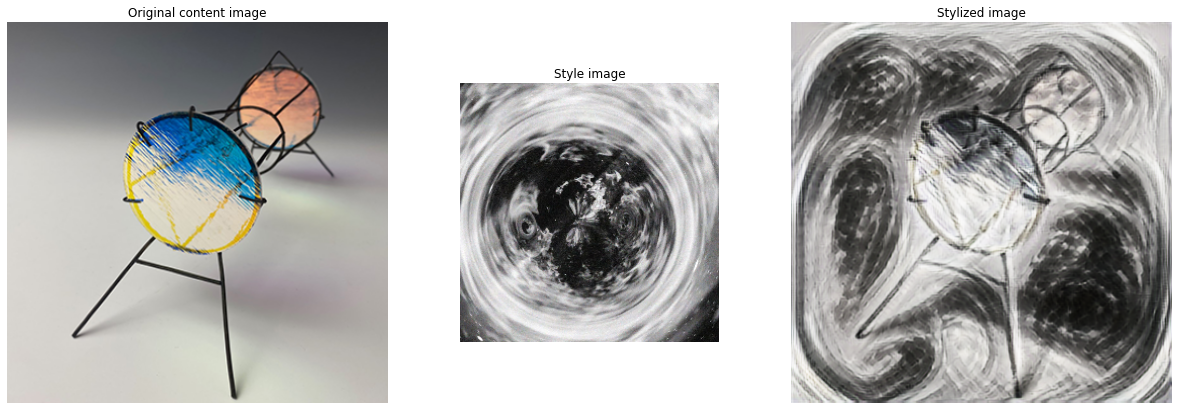

In [24]:
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

In [43]:
content_urls = dict(
  sea_turtle='https://imgur.com/kHZSqFd.jpeg',
  tuebingen='https://imgur.com/dPr5sKZ.jpeg',
  grace_hopper='https://imgur.com/dPr5sKZ.jpeg',
  )
style_urls = dict(
#   kanagawa_great_wave='https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
#   kandinsky_composition_7='https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
   hubble_pillars_of_creation='https://imgur.com/dPr5sKZ.jpeg',
#   van_gogh_starry_night='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
#   turner_nantes='https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg',
#  munch_scream='https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
#   picasso_demoiselles_avignon='https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
   picasso_violin='https://imgur.com/kHZSqFd.jpeg',
#   picasso_bottle_of_rum='https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
#   fire='https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg',
#   derkovits_woman_head='https://upload.wikimedia.org/wikipedia/commons/0/0d/Derkovits_Gyula_Woman_head_1922.jpg',
#   amadeo_style_life='https://upload.wikimedia.org/wikipedia/commons/8/8e/Untitled_%28Still_life%29_%281913%29_-_Amadeo_Souza-Cardoso_%281887-1918%29_%2817385824283%29.jpg',
#   derkovtis_talig='https://upload.wikimedia.org/wikipedia/commons/3/37/Derkovits_Gyula_Talig%C3%A1s_1920.jpg',
#   amadeo_cardoso='https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg',
#  colorful_lion='https://www.artmajeur.com/medias/standard/t/h/thecolorterrace/artwork/10123252_lion-print-file.jpg',
#   cartoon_like='https://github.com/lengstrom/fast-style-transfer/raw/master/examples/style/rain_princess.jpg'
)

content_image_size = 384
style_image_size = 256
content_images = {k: load_image(v, (content_image_size, content_image_size)) for k, v in content_urls.items()}
style_images = {k: load_image(v, (style_image_size, style_image_size)) for k, v in style_urls.items()}
style_images = {k: tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME') for k, style_image in style_images.items()}

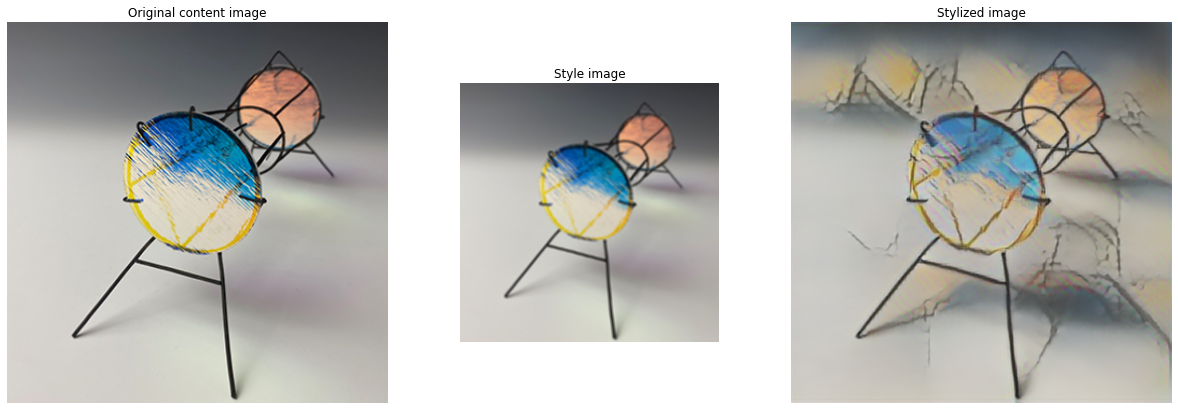

In [44]:
content_name = 'sea_turtle'  # @param ['sea_turtle', 'tuebingen', 'grace_hopper']
style_name = 'picasso_violin'  # @param ['kanagawa_great_wave', 'kandinsky_composition_7', 'hubble_pillars_of_creation', 'van_gogh_starry_night', 'turner_nantes', 'munch_scream', 'picasso_demoiselles_avignon', 'picasso_violin', 'picasso_bottle_of_rum', 'fire', 'derkovits_woman_head', 'amadeo_style_life', 'derkovtis_talig', 'amadeo_cardoso']

stylized_image = hub_module(tf.constant(content_images[content_name]),
                            tf.constant(style_images[style_name]))[0]

show_n([content_images[content_name], style_images[style_name], stylized_image],
       titles=['Original content image', 'Style image', 'Stylized image'])

In [19]:
import cv2

#this is where we lay out which video we're using as the base, which video codec we want to save as, size and location)

cap = cv2.VideoCapture(r"C:\Users\dsroj\OneDrive\Desktop\Event Horizon.mp4")
frame_size=1024

fourc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(r"C:\Users\dsroj\OneDrive\Desktop\event_horizon_stylizoed.mp4", fourc, 60.0, (frame_size,frame_size))
style_name="picasso_violin"
print(f"Using style_name={style_name}")
counter = 0
while True:
    print(f"{counter}")
                    
    flag,frame=cap.read()
    if flag: 
        image_rgb_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        #print(image_rgb_np)
        resized_image_np = resize_image_to_square(image_rgb_np, image_size=(frame_size,frame_size))
        
        outputs = hub_module(tf.constant(resize_image_np), tf.constant(style_images[style_name]))
        stylized_image = outputs[0]
        image_pil = tf.keras.preprocessing.image.array_to_img(stylized_image[0])
        
        image_bgr_np=cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
        
        out.write(image_bgr_np)
    else:
        break
        
    counter = counter + 1

out.release()
        

Using style_name=picasso_violin
0


NameError: name 'resize_image_to_square' is not defined